<a href="https://colab.research.google.com/github/monksealseal/AtmosphericDynamics/blob/main/run_AIFS_ENS_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook runs ECMWF's aifs-ens-v1 data-driven model, using ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset and the [anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

aifs-ens-v1 is designed to be an inhererently uncertain model, meaning that for the same initial conditions, different noise is applied within the model and a different forecast will be provided. Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. Operational AIFS ENS forecast data can be found in ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset.

# 1. Install Required Packages and Imports


In [2]:
## Uncomment the lines below to install the required packages
!pip install torch==2.5.0 anemoi-inference[huggingface]==0.6.0 anemoi-models==0.6.0 anemoi-graphs==0.6.0 anemoi-datasets==0.5.23
!pip install earthkit-regrid==0.4.0 'ecmwf-opendata>=0.3.19'
!pip install flash_attn

  Using cached ecmwf_opendata-0.3.22-py3-none-any.whl.metadata (22 kB)
Using cached ecmwf_opendata-0.3.22-py3-none-any.whl (20 kB)
  Using cached flash_attn-2.8.1.tar.gz (8.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.8.1-cp311-cp311-linux_x86_64.whl size=126076958 sha256=e7f0c4b5a0685c15e449a3db7f6efe25b955d6b153d1acdc3208b136738513a3
  Stored in directory: /root/.cache/pip/wheels/fe/e8/f9/c737fa70cd4a4c0cf9f0d7e3b08b669b69893e7a1591919214
Successfully built flash_attn


In [3]:
import datetime
from collections import defaultdict

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from ecmwf.opendata import Client as OpendataClient


# 2. Retrieve Initial Conditions from ECMWF Open Data
## List of parameters to retrieve form ECMWF open data


In [4]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw"]
PARAM_SFC_FC = ["lsm", "z", "slor", "sdor"]
PARAM_SOIL =["sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1,2]


## Select a date

In [5]:
DATE = OpendataClient("ecmwf").latest()
print("Initial date is", DATE)

Initial date is 2025-07-15 06:00:00


## Get the data from the ECMWF Open Data API


In [6]:
def get_open_data(param, levelist=[], number = None):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        if number is None:
            data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        else:
            data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist, number=[number], stream='enfo')

        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721,1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

## Get Input Fields

> Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions.

To get different ensemble initial conditions from the ifs pertubation, set `number` to an ensemble number, between 1-50.


In [7]:
fields = {}
number = None

### Add the single levels fields


In [8]:
fields.update(get_open_data(param=PARAM_SFC, number=number))
fields.update(get_open_data(param=PARAM_SFC_FC)) # Add constant surface fields, retrieved from fc

<multiple>:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

9533e90f8433424400ab53c7fafc87ba1a04453093311c0b5bd0b35fedc1fb83.npz:   0%|          | 0.00/7.11M [00:00<?, ?B…

<multiple>:   0%|          | 0.00/5.13M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

In [9]:
soil=get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS, number=number)

20250715000000-0h-oper-fc.grib2:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

20250715060000-0h-scda-fc.grib2:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

Soil parameters have been renamed since training this model, we need to rename to the original names

In [10]:
mapping = {'sot_1': 'stl1', 'sot_2': 'stl2',
           'vsw_1': 'swvl1','vsw_2': 'swvl2'}
for k,v in soil.items():
    fields[mapping[k]]=v

### Add the pressure levels fields


In [11]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS, number=number))

<multiple>:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

<multiple>:   0%|          | 0.00/54.3M [00:00<?, ?B/s]

### Convert geopotential height into geopotential

In [12]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

## Create Initial State

In [13]:
input_state = dict(date=DATE, fields=fields)

# 3. Load the Model and Run the Forecast

## Download the Model's Checkpoint from Hugging Face & create a Runner


In [14]:
checkpoint = {"huggingface":"ecmwf/aifs-ens-1.0"}

To reduce the memory usage of the model certain environment variables can be set, like the number of chunks of the model's mapper. Please refer to:

https://anemoi.readthedocs.io/projects/models/en/latest/modules/layers.html#anemoi-inference-num-chunks

https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf

for more information. To do so, you can use the code below:

```
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True'
os.environ['ANEMOI_INFERENCE_NUM_CHUNKS']='16'
```

In [15]:
runner = SimpleRunner(checkpoint, device="cuda")

### Run the forecast

In [25]:
for state in runner.run(input_state=input_state, lead_time=120):
    print_state(state)


😀 date=2025-07-15T12:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=7.48344e-07    max=3.67306e-06   
    t_1000 shape=(542080,) min=227.995        max=321.112       
    v_925  shape=(542080,) min=-32.8768       max=30.223        
    z_850  shape=(542080,) min=8536.26        max=16560.3       
    ro     shape=(542080,) min=0              max=0.00930293    


😀 date=2025-07-15T18:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=7.18209e-07    max=3.55252e-06   
    t_1000 shape=(542080,) min=227.896        max=319.747       
    v_925  shape=(542080,) min=-34.5092       max=29.7279       
    z_850  shape=(542080,) min=8629.4         max=16613.3       
    ro     shape=(542080,) min=0              max=0.00961432    


😀 date=2025-07-16T00:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=7.4177e-07     max=3.52737e-06   
    t_1000 shape=(542080,) min=226.028  

# 4. Inspect the generated forecast

### Plot a field


In [17]:
# To be able to run the plotting section below you need to install additional dependencies

!pip install -q matplotlib cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 75.5 MB/s eta 0:00:00


In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

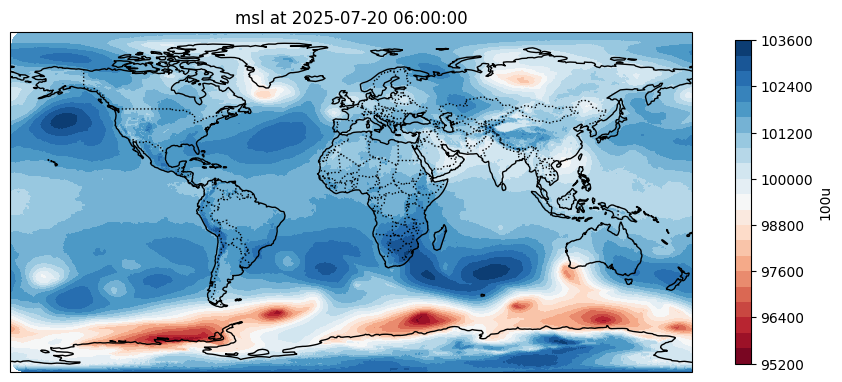

In [38]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["msl"]

fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="100u")

plt.title("msl at {}".format(state["date"]))
plt.show()